### Cookie Cats

Cookie Cats — чрезвычайно популярная мобильная игра, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедините три», в которой игрок должен соединять плитки одного цвета, чтобы очистить поле и выиграть уровень. Здесь также есть поющие кошки.

По мере прохождения уровней игроки время от времени сталкиваются с воротами, которые заставляют их ждать или совершать покупки в приложении, чтобы продолжить. Помимо стимулирования покупок в приложении, эти ворота дают игрокам вынужденный перерыв в игре, что, как мы надеемся, приведёт к увеличению времени, проведённому в игре, и продлению удовольствия от игры.

<b>Но где ставить ворота? </b>
Изначально первые ворота были размещены на уровне `30`. В этом проекте проанализируем A/B-тест, в котором создатели переместили первые ворота в Cookie Cats с `30` уровня на уровень `40` и постараемся сделать выводы о том, имела ли перестановка ворот положительное влияние на онлайн в игре.

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cookie_cats = 'https://raw.githubusercontent.com/a-milenkin/datasets_for_t-tests/main/cookie_cats.csv'

data = pd.read_csv(cookie_cats, error_bad_lines=False)
data.head()

<ipython-input-47-7a087f31d071>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(cookie_cats, error_bad_lines=False)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


**Данные получены от 90 189 игроков, которые установили игру во время проведения A/B-теста. Переменные:**

* `userid` - уникальный номер, идентифицирующий каждого игрока.
* `version` - был ли игрок помещён в контрольную группу (gate_30 - ворота на уровне 30) или в тестовую группу (gate_40 - ворота на уровне 40).
* `sum_gamerounds` - количество игровых раундов, сыгранных игроком в течение первой недели после установки
* `retention_1` - игрок вернулся и поиграл через 1 день после установки?
* `retention_7` - игрок вернулся и играл через 7 дней после установки?

Когда игрок устанавливал игру, ему случайным образом назначали `gate_30` или `gate_40`.

#### Цель исследования: провести анализ данных и сделать выводы о лучшем месте для установки ворот.
    

In [ ]:
data.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


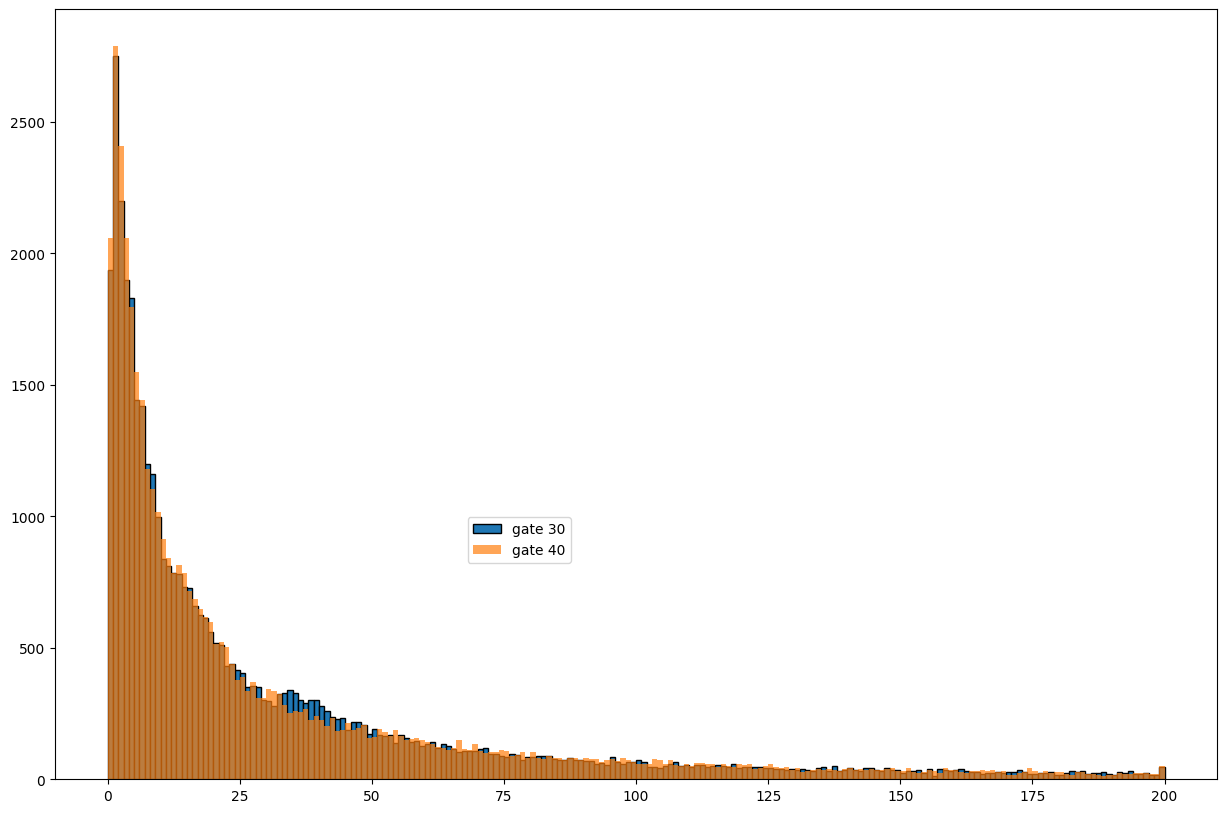

In [ ]:
v_30 = data.loc[data.version == 'gate_30']
v_40 = data.loc[data.version == 'gate_40']
v_30 = v_30.drop(v_30.loc[v_30.sum_gamerounds > 200].index)
v_40 = v_40.drop(v_40.loc[v_40.sum_gamerounds > 200].index)


bins = 200
plt.figure(figsize=(15, 10))
plt.hist(v_30['sum_gamerounds'], bins=bins, alpha=1, edgecolor='black', label='gate 30')
plt.hist(v_40['sum_gamerounds'], bins=bins, alpha=0.7, label='gate 40')
plt.legend(loc='upper right', bbox_to_anchor=(0.45, 0.35))
plt.show()

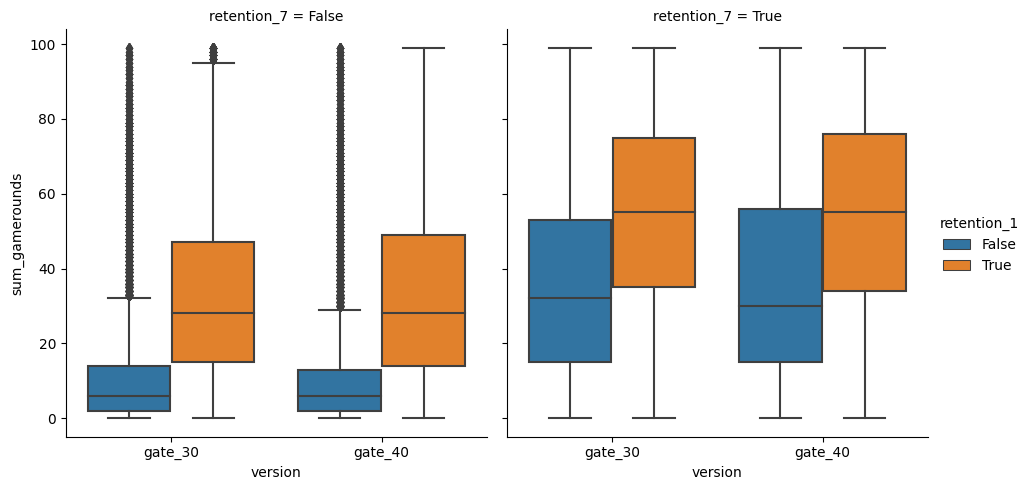

In [ ]:
df = data.loc[data['sum_gamerounds'] < 100].copy();


sns.catplot(x="version", y="sum_gamerounds",
            hue="retention_1", col = 'retention_7',
            data=df, kind="box",
            height=5, aspect=.95);

Проще представить визуализацию можно так:

<Axes: ylabel='Density'>

<Figure size 1500x1000 with 0 Axes>

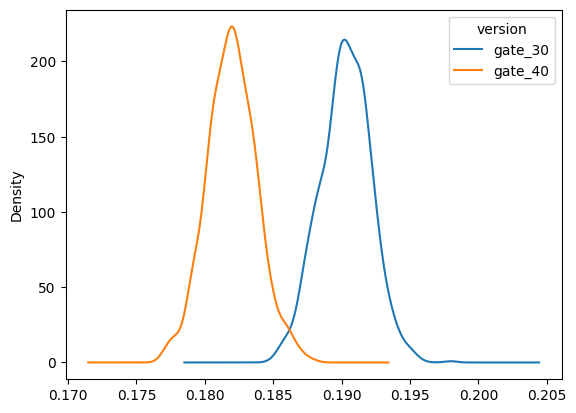

In [ ]:
plt.figure(figsize=(15, 10))

boot_1d = []
for i in range(1000):
    boot_mean = data.sample(frac = 1, replace = True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
boot_1d.plot(kind='density')

Для начала проверим дисперсию по критерию Фишера

In [ ]:
A = data[data['version'] == 'gate_30']['sum_gamerounds']
B = data[data['version'] == 'gate_40']['sum_gamerounds']

fvalue, pvalue = st.f_oneway(A, B)

print('Статистика=%.3f, p=%.6f' % (fvalue, pvalue))
if pvalue > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=0.794, p=0.372909
Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые


Все ок, критерий Фишера подсказывает нам, что выборки независимы, каждая выборка взята из нормально распределенных данных, а, главное, что мы можем продолжать наше исследование.

In [ ]:
stat, p = st.ttest_ind(A, B)
print('Статистика=%.3f, p=%.10f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу')
else:
    print('Отклоняем нулевую гипотезу')

Статистика=-3.687, p=0.0003544849
Отклоняем нулевую гипотезу


p-value стремится к нулю, это означает, что средние в выборках разные и существует статистическая разница между тем, куда ставить ворота. Статистически Gate 30 показывает более лучшие результаты.